# Feedback circuit

The genetic feedback circuit is given by
$$
    \mathrm{D}_i \xrightarrow{C^m_i} \mathrm{D}_i + \mathrm{M}_i \\
    \mathrm{M}_i \xrightarrow{C^p_i} \mathrm{M}_i + \mathrm{P}_i \\
    \mathrm{D}_i + \mathrm{P}_i \xrightarrow{c^a} \mathrm{DP}_i \\
    \mathrm{DP}_i + \mathrm{P}_i \xrightarrow{c^d} \mathrm{D}_i + \mathrm{P}_i \\
    \mathrm{DP}_i \xrightarrow{c^f} \mathrm{DP}_i + \mathrm{M}_i \\
    \mathrm{M}_i \xrightarrow{d^m} \emptyset \\
    \mathrm{P}_i \xrightarrow{d^p} \emptyset \\
    \mathrm{P}_i \xrightarrow{c^t} \mathrm{Q} \\ 
    \mathrm{Q} \xrightarrow{c^t} \mathrm{P}_i \\
$$

for $i=1, \ldots, N$. Here, we consider the reaction rate constants associated with transcription $C^m_i$ and translation $C^p_i$ to be randomly distributed across the population, while all other rate parameters are fixed.

## Symmetry-reduced moment dynamics
This system can be described with a symmetry-reduced model of up to the second order using $\hat{K}_{eq}=48$ differential equations regardless of the population size. The system is non-closed due to the extrinsic noise of the transcription and translation reaction rate constants. To solve for the moment dynamics, we used a lognormal moment-closure approximation (MA). We solved for moment dynamics for a population of $N=10$ cells and induction rates corresponding to negative feedback $c^f=0.1$ and positive feedback $c^f=1$.

**Moment equations for the reduced-model were manually written down so this section only applies to the given set parameters.**

In [1]:
# Import required modules.
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from feedback_functions import * 

# Solve moments for negative feedback.
u_nfb = solve_moments_nfb()
# Solve moments for positive feedback.
u_pfb = solve_moments_pfb(10)

# Format results into Pandas dataframe.
u_stack = np.vstack((u_nfb['y'].transpose(), u_pfb['y'].transpose())) 
u_df = pd.DataFrame(u_stack, columns=['D0', 'M0', 'P0', 'DP0', 'Ss', 
                                      'D0**2', 'D0*M0', 'D0*P0', 'D0*DP0', 'D0*Ss', 
                                      'D0*D1', 'D0*M1', 'D0*P1', 'D0*DP1', 'D0*km0', 
                                      'D0*kp0', 'D0*km1', 'D0*kp1', 'M0**2', 'M0*P0', 
                                      'DP0*M0', 'M0*Ss', 'M0*M1', 'M0*P1', 'M0*km0', 
                                      'M0*kp0', 'M0*km1', 'M0*kp1', 'P0**2', 'DP0*P0', 
                                      'P0*Ss', 'P0*P1', 'P0*km0', 'P0*kp0', 'P0*km1', 
                                      'P0*kp1', 'DP0**2', 'DP0*Ss', 'DP0*M1', 'DP0*P1', 
                                      'DP0*DP1', 'DP0*km0', 'DP0*kp0', 'DP0*km1', 'DP0*kp1', 
                                      'Ss**2', 'Ss*km0', 'Ss*kp0'])
u_df.index = np.tile(u_nfb['t'],2)
u_df['Time'] = np.tile(u_nfb['t'],2)
u_df['ki'] = np.repeat([0.1, 1], 100)
u_df['Std(M0)'] = ((u_df['M0**2']-u_df['M0']**2))**0.5
u_df['Std(P0)'] = ((u_df['P0**2']-u_df['P0']**2))**0.5
u_df['Std(DP0)'] = ((u_df['DP0**2']-u_df['DP0']**2))**0.5
u_df['Std(Ss)'] = ((u_df['Ss**2']-u_df['Ss']**2))**0.5
u_df['CV(P0)'] = u_df['Std(P0)']/u_df['P0']
u_df['CV(M0)'] = u_df['Std(M0)']/u_df['M0']
u_df['Var(P0-P1)'] = (2*u_df['P0**2']-2*u_df['P0*P1'])
u_df['Var(P0)'] = u_df['P0**2']-u_df['P0']**2
u_df['Var(M0-M1)'] = (2*u_df['M0**2']-2*u_df['M0*M1'])
u_df['Var(M0)'] = u_df['M0**2']-u_df['M0']**2

# Save moment results.
u_df.to_csv('feedback_moments.csv', sep = ';')

## Stochastic simulations
We compared the approximated moment dynamics with moments calculated from exact SSA runs for both the negative and positive feedback cases. 95% confidence intervals were calculated by bootstrapping the SSA results.

In [2]:
# Import required modules.
import pandas as pd
import numpy as np
from feedback_functions import * 

# Run SSAs and compile into dataframe.
runs = 200 # We used 1000 for our results. It just takes longer to finish.
N = 10
s_df = pd.DataFrame()
for ki in [0.1, 1]: # Different induction rates.
    s_stack_df = runSSA(N, runs, ki)
    s_df = s_df.append(s_stack_df, sort='True')
    
pts = 100
bs_set = pd.DataFrame(columns={'lower','upper','ki','typ'})
for ki in [0.1, 1]:
    sub_s = s_df[(s_df['ki']==ki)]
    if np.shape(sub_s)[0] != 0:
        sub_s.insert(44, '(M0-M1)^2', (sub_s['M0']-sub_s['M1'])**2)
        a = bootstrapping(sub_s, 'mean', runs, pts, ['M0'])
        b = bootstrapping(sub_s, 'var', runs, pts, ['M0'])
        c = bootstrapping(sub_s, 'cv', runs, pts, ['M0'])
        d = bootstrapping(sub_s, 'pv', runs, pts, ['(M0-M1)^2','M0','M1'])
        bootstrap = pd.concat((a,b,c,d), sort = False)
        bootstrap['ki'] = np.repeat(ki, np.shape(bootstrap)[0])
        bootstrap['typ'] = np.repeat(['mean','var','cv','pv'], np.shape(bootstrap)[0]/4)
        bs_set = pd.concat((bs_set, bootstrap), sort = False)
        
# Save results.
s_df.to_csv('feedback_ssa.csv', sep = ';')
bs_set.to_csv('feedback_bs.csv', sep = ';')

## Plot results
This section recreates Figure 6 in the paper from the saved results.

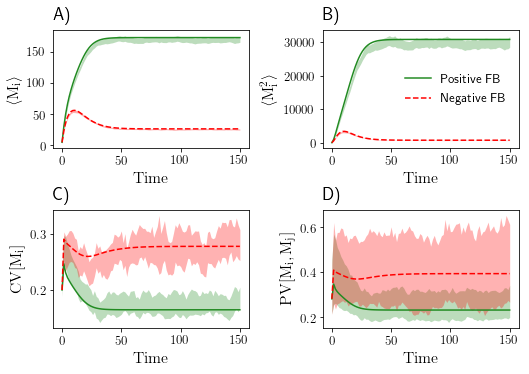

In [3]:
# Import required modules.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Open saved results.
u_df = pd.read_csv('feedback_moments.csv', sep = ';', index_col=0 )
bs_set = pd.read_csv('feedback_bs.csv', sep = ';', index_col=0)

# Set figure format.
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 13
matplotlib.rcParams['ytick.labelsize'] = 13
matplotlib.rcParams['axes.titlesize'] = 18
matplotlib.rcParams['lines.linewidth'] = 1.5
matplotlib.rcParams['legend.fontsize'] = 13
matplotlib.rcParams['axes.titlepad'] = 10

plt.figure(figsize=(7.5,5.3))
bg_color = ['red', 'forestgreen', 'dodgerblue']
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

# Plot results.
plt.subplot(2,2,1)
k = 0.8
s = 'M0'   
sub_u = u_df[(u_df['ki']==1)]
ci = bs_set[(bs_set['ki']==1) & (bs_set['typ']=='mean')]
plt.fill_between(sub_u['Time'], ci['lower'], ci['upper'], color = bg_color[1], alpha =0.3, label = '_nolegend_', linewidth=0)
plt.plot(sub_u['Time'], sub_u[s], color = bg_color[1], linestyle = '-', linewidth = 1.5, label = 'Positive FB')
sub_u = u_df[(u_df['ki']==0.1)]
ci = bs_set[(bs_set['ki']==0.1) & (bs_set['typ']=='mean')]
plt.fill_between(sub_u['Time'], ci['lower'], ci['upper'], color = bg_color[0], alpha =0.3, label = '_nolegend_', linewidth=0)
plt.plot(sub_u['Time'], sub_u[s], color = bg_color[0], linestyle = '--', linewidth = 1.5, label = 'Negative FB')
plt.xlabel('$\mathrm{Time}$')
plt.ylabel(r'$\langle \mathrm{M_i} \rangle$')
plt.title('A)', loc = 'left')

plt.subplot(2,2,2)
s = 'M0**2'
sub_u = u_df[(u_df['ki']==1)]
ci = bs_set[(bs_set['ki']==1) & (bs_set['typ']=='var')]
plt.fill_between(sub_u['Time'], ci['lower'], ci['upper'], color = bg_color[1], alpha =0.3, label = '_nolegend_', linewidth=0)
plt.plot(sub_u['Time'], sub_u[s], color = bg_color[1], linestyle = '-', linewidth = 1.5, label = 'Positive FB')
sub_u = u_df[(u_df['ki']==0.1)]
ci = bs_set[(bs_set['ki']==0.1) & (bs_set['typ']=='var')]
plt.fill_between(sub_u['Time'], ci['lower'], ci['upper'], color = bg_color[0], alpha =0.3, label = '_nolegend_', linewidth=0)
plt.plot(sub_u['Time'], sub_u[s], color = bg_color[0], linestyle = '--', linewidth = 1.5, label = 'Negative FB')
plt.xlabel('$\mathrm{Time}$')
plt.ylabel(r'$\langle \mathrm{M_i^2} \rangle$')
plt.legend(frameon = False, loc = 7)
plt.title('B)', loc = 'left')

plt.subplot(2,2,3)
sub_u = u_df[(u_df['ki']==1)]
ci = bs_set[(bs_set['ki']==1) & (bs_set['typ']=='cv')]
plt.fill_between(sub_u['Time'], ci['lower'], ci['upper'], color = bg_color[1], alpha =0.3, label = '_nolegend_', linewidth=0)
plt.plot(sub_u['Time'], sub_u['CV(M0)'], color = bg_color[1], linestyle = '-', linewidth = 1.5, label = 'Positive FB')
sub_u = u_df[(u_df['ki']==0.1)]
ci = bs_set[(bs_set['ki']==0.1) & (bs_set['typ']=='cv')]
plt.fill_between(sub_u['Time'], ci['lower'], ci['upper'], color = bg_color[0], alpha =0.3, label = '_nolegend_', linewidth=0)
plt.plot(sub_u['Time'], sub_u['CV(M0)'], color = bg_color[0], linestyle = '--', linewidth = 1.5, label = 'Negative FB')
plt.ylabel('$\mathrm{CV[M_i]}$')
plt.xlabel('$\mathrm{Time}$')
plt.title('C)', loc = 'left')

plt.subplot(2,2,4)
sub_u = u_df[(u_df['ki']==1)]
ci = bs_set[(bs_set['ki']==1) & (bs_set['typ']=='pv')]
plt.fill_between(sub_u['Time'], ci['lower'], ci['upper'], color = bg_color[1], alpha =0.3, label = '_nolegend_', linewidth=0)
plt.plot(sub_u['Time'], (sub_u['Var(M0-M1)']/(sub_u['M0']**2))**0.5, color = bg_color[1], linestyle = '-', label = 'Positive FB')
sub_u = u_df[(u_df['ki']==0.1)]
ci = bs_set[(bs_set['ki']==0.1) & (bs_set['typ']=='pv')]
plt.fill_between(sub_u['Time'], ci['lower'], ci['upper'], color = bg_color[0], alpha =0.3, label = '_nolegend_', linewidth=0)
plt.plot(sub_u['Time'], (sub_u['Var(M0-M1)']/(sub_u['M0']**2))**0.5, color = bg_color[0], linestyle = '--', linewidth = 1.5, label = 'Negative FB')
plt.ylabel('$\mathrm{PV[M_i,M_j]}$')
plt.xlabel('$\mathrm{Time}$')
plt.title('D)', loc = 'left')
plt.tight_layout(h_pad=-0.05)

plt.savefig('genefeedback.pdf', pad_inches=0)
plt.show()

## Run time of reduced moments vs. SSA

This section compares the run times of 1 SSA sample path and solving the moment equations of the reduced model for different population sizes $N = [10, 100, 1000]$.

In [4]:
# Import required modules.
import pandas as pd
import numpy as np
from feedback_functions import * 
from timeit import default_timer as timer

# Setup reaction model in Tellurium.
N = 10 # Change population size here.
ki = 1 # Positive feedback case.
i_mean = np.array([30, 5, 5, 5, 5]) 
i_std = np.array([5, 1, 1, 1, 0])
i_logmean = np.nan_to_num(np.log(i_mean**2/np.sqrt(i_mean**2+i_std**2)))
i_logsigma = np.nan_to_num(np.sqrt(np.log(1+((i_std**2)/(i_mean**2)))))
# km, kp, ka, kd, ki, dm, dp, kout, kin
k_mean = np.array([0.5, 0.05, 0.01, 0.01, ki, 0.2, 0.2, 0.8, 0.8])
k_std = np.array([0.1, 0.005, 0, 0, 0, 0, 0, 0, 0])
with np.errstate(all='ignore'): # Divide by zero errors are from homogeneous rate parameters only and not used.
    k_logmean = np.nan_to_num(np.log(k_mean**2/np.sqrt(k_mean**2+k_std**2)))
    k_logsigma = np.nan_to_num(np.sqrt(np.log(1+((k_std**2)/(k_mean**2)))))
initials = np.random.lognormal(i_logmean, i_logsigma, size = (N, len(i_logmean)))
rates = np.random.lognormal(k_logmean, k_logsigma, size = (N, len(k_logmean)))
writeFeedback(initials.astype(int), rates, N)
path = 'feedback.ant'
r = te.loada(path)
r.integrator = 'gillespie'
selections = ['time'] + r.getFloatingSpeciesIds()
r.integrator.variable_step_size = False

# Time SSA sample paths.
times = np.array([])
for i in range(10): # Number of replicates.
    start = timer()
    r.resetToOrigin()
    s = r.simulate(0, 150, 100, selections=selections)
    end = timer()
    times = np.append(times,end-start)

# Print results.
print ('Run time of 1 SSA sample path (N = %d):' %N)
print ('Mean: ' + str(np.mean(times)))
print ('Stdev: ' + str(np.std(times)))

Run time of 1 SSA sample path (N = 10):
Mean: 0.1575269657
Stdev: 0.00548485351022


In [5]:
# Import required modules.
import pandas as pd
import numpy as np
from feedback_functions import * 
from timeit import default_timer as timer

# Setup moment equations.
N = 10 # Set population size N.
t_span = (0,150)
t_steps = np.linspace(0, 150, 100)
# D, M, P, DP, Ss
i_mean = np.array([30, 5, 5, 5, 5]) 
i_std = np.array([5, 1, 1, 1, 0])
# km, kp, ka, kd, ki, dm, dp, kout, kin
k_mean = np.array([0.5, 0.05, 0.01, 0.01, 1, 0.2, 0.2, 0.8, 0.8])
k_std = np.array([0.1, 0.005, 0, 0, 0, 0, 0, 0, 0])
A = closed_moments_pfb(N)
initial = initialize()

# Time solving reduced moment equations.
times = np.array([])
for i in range(10): # Number of replicates.
    start = timer()
    u = solve_ivp(lambda t,y: approx_moments_pfb(y, t, A, k_mean, k_std), t_span, initial, t_eval = t_steps, method = 'Radau')
    end = timer()
    times = np.append(times,end-start)

# Print results.
print ('Run time of moment equations (N = %d):' %N)
print ('Mean: ' + str(np.mean(times)))
print ('Stdev: ' + str(np.std(times)))

Run time of moment equations (N = 10):
Mean: 0.0540798782999
Stdev: 0.00271690238874
